In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dowhy
import shap
import warnings
from dowhy import CausalModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../data/training_data_original.csv')

In [3]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


### Check for duplicate tracks and remove the lowest popularity song

In [4]:
df = df.sort_values('track_popularity', ascending=False).drop_duplicates('track_name').sort_index()

# Only keep songs wiht popularity > 0
df = df[df['track_popularity'] > 0]

### Convert time to minutes from milliseconds 

In [5]:
# Convert duration_ms to minutes with 2 decimal places
df['duration_mins'] = df['duration_ms'] / 60000
df['duration_mins'] = df['duration_mins'].round(2)

#drop duration_ms
df = df.drop(columns=['duration_ms'])

In [6]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,3.25
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,2.94
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,2.82
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,3.15
6,6b1RNvAcJjQH73eZO4BLAB,Post Malone (feat. RANI) - GATTÜSO Remix,Sam Feldt,69,6703SRPsLkS4bPtMFFJes1,Post Malone (feat. RANI) [GATTÜSO Remix],2019-08-29,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.542,0.903,4,-2.419,0,0.0434,0.0335,0.000005,0.1110,0.367,127.936,3.46


### Create new column `release_year` to capture the year of the song release

In [7]:
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')
df['release_year'] = df['track_album_release_date'].dt.year

### Remove unwanted columns

In [8]:
df = df.drop(columns=['track_id', 'track_name', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id'])

### Causal model building

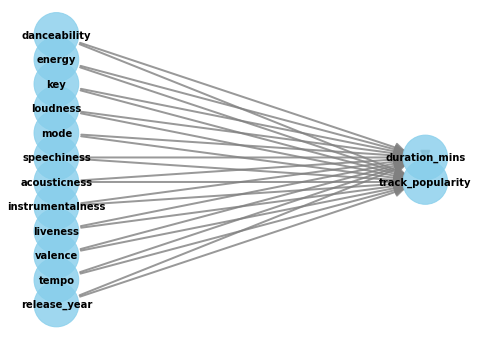

In [9]:
causal_model = CausalModel(
    data=df,
    treatment=['duration_mins'],
    outcome='track_popularity',
    common_causes=df.drop(columns=['track_artist','playlist_genre','playlist_subgenre'  ,'duration_mins', 'track_popularity']).columns.tolist(),
    effect_modifiers=['release_year']
)

causal_model.view_model()

In [10]:
identified_effect = causal_model.identify_effect()

print(identified_effect)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[track_popularity|speechiness,danceability,valence,energy,mod
d[durationₘᵢₙₛ]                                                               

                                                                          
e,acousticness,release_year,liveness,loudness,tempo,instrumentalness,key])
                                                                          
Estimand assumption 1, Unconfoundedness: If U→{duration_mins} and U→track_popularity then P(track_popularity|duration_mins,speechiness,danceability,valence,energy,mode,acousticness,release_year,liveness,loudness,tempo,instrumentalness,key,U) = P(track_popularity|duration_mins,speechiness,danceability,valence,energy,mode,acousticness,release_year,liveness,loudness,tempo,instrumentalness,key)

### Estimand : 2
Estimand name: i

In [11]:
causal_estimate = causal_model.estimate_effect(identified_effect, method_name="backdoor.linear_regression", target_units="ate")

print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[track_popularity|speechiness,danceability,valence,energy,mod
d[durationₘᵢₙₛ]                                                               

                                                                          
e,acousticness,release_year,liveness,loudness,tempo,instrumentalness,key])
                                                                          
Estimand assumption 1, Unconfoundedness: If U→{duration_mins} and U→track_popularity then P(track_popularity|duration_mins,speechiness,danceability,valence,energy,mode,acousticness,release_year,liveness,loudness,tempo,instrumentalness,key,U) = P(track_popularity|duration_mins,speechiness,danceability,valence,energy,mode,acousticness,release_year,liveness,loudness,tempo,instrume

In [12]:
estimate = causal_model.estimate_effect(identified_effect, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[track_popularity|speechiness,danceability,valence,energy,mod
d[durationₘᵢₙₛ]                                                               

                                                                          
e,acousticness,release_year,liveness,loudness,tempo,instrumentalness,key])
                                                                          
Estimand assumption 1, Unconfoundedness: If U→{duration_mins} and U→track_popularity then P(track_popularity|duration_mins,speechiness,danceability,valence,energy,mode,acousticness,release_year,liveness,loudness,tempo,instrumentalness,key,U) = P(track_popularity|duration_mins,speechiness,danceability,valence,energy,mode,acousticness,release_year,liveness,loudness,tempo,instrume

In [14]:
# Refutation analysis to test the robustness of the causal estimate
refutation_results_rcc = causal_model.refute_estimate(
    identified_effect,
    causal_estimate,
    method_name="random_common_cause",
    test_significance=True,
)

print(refutation_results_rcc)


Refute: Add a random common cause
Estimated effect:-1.99015268113331
New effect:-1.989925884771656
p value:0.94



In [15]:
refutation_results_subset = causal_model.refute_estimate(
    identified_effect,
    causal_estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.9,
    test_significance=True,
)

print(refutation_results_subset)

Refute: Use a subset of data
Estimated effect:-1.99015268113331
New effect:-1.9907912764984113
p value:0.96



In [17]:
refutation_results_bootstrap = causal_model.refute_estimate(
    identified_effect,
    causal_estimate,
    method_name="bootstrap_refuter",
    num_simulations=100,
    test_significance=True,
)

print(refutation_results_bootstrap)

Refute: Bootstrap Sample Dataset
Estimated effect:-1.99015268113331
New effect:-1.9989416593597826
p value:0.94



# Model Building

### Random Forest

In [41]:
# For one-hot encofing thse 3 variables;

# df_encoded = pd.get_dummies(df, columns=['track_artist', 'playlist_genre', 'playlist_subgenre'])

In [43]:
from sklearn.model_selection import train_test_split

X = df.drop(['track_popularity', 'track_artist', 'playlist_genre', 'playlist_subgenre'], axis=1) 
y = df['track_popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [44]:
rf_regressor = RandomForestRegressor(random_state=13)
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 19.510582782801738


In [47]:
from sklearn.metrics import r2_score

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Print accuracy metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²) score: {r2}")

# Feature Importance
feature_importances = rf_regressor.feature_importances_
# Create a DataFrame for easier visualization
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
# Sort the DataFrame by importance
features_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances
print(features_df)

Root Mean Squared Error (RMSE): 19.510582782801738
R-squared (R²) score: 0.08708426879702713
             Feature  Importance
7   instrumentalness    0.092630
3           loudness    0.092047
10             tempo    0.092017
5        speechiness    0.088226
11     duration_mins    0.088138
1             energy    0.086407
6       acousticness    0.085881
0       danceability    0.083882
9            valence    0.082488
8           liveness    0.082159
12      release_year    0.075040
2                key    0.041898
4               mode    0.009186


### SHAP Value plot

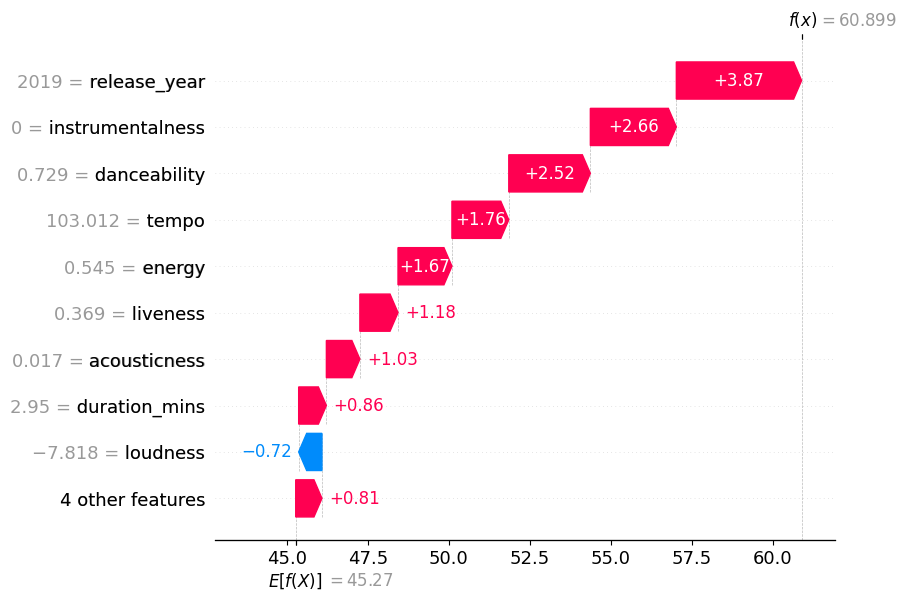

In [48]:
explainer = shap.Explainer(rf_regressor, X_train)

shap_values = explainer(X_train.iloc[0:1, :])

shap.plots.waterfall(shap_values[0], show=False)
plt.show()
